# Tasks

- Use sklearn's `explained_variance_ratio_`to determine the number of components needed for a given threshold.
- Use the `explained_variance_ratio_` function to plot the cumulative explained variance ratio.

- Use the `variance_explained` function to plot the first digit of the dataset with different thresholds.
- Compare the running time of the logistic regression with and without PCA.
- Compare the accuracy between the prediction with and without PCA. 

# Imports

In [1]:
# standard imports
import numpy as np


# sklearn
import sklearn
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# other useful imports
from importlib import reload
from time import time


# imports for plotting
import matplotlib.pyplot as plt

import seaborn as sns


#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')


# custom imports
#from customlib import CustomPCA as CustomPCA
#from customlib import plotting as pl
import CustomPCA as CustomPCA
import plotting as pl

In [2]:
%matplotlib inline
#sns.set_style('whitegrid', {'axes.facecolor': '.95'})
plt.style.use('custom_plot_style.mplstyle') # use the custom style sheet

In [3]:
%reload_ext watermark
%watermark -a "Author: Nicole Königstein" 
%watermark -d -v -m 
%watermark -v -p numpy,pandas

Author: Author: Nicole Königstein

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy : 1.25.2
pandas: 2.0.3



# Use PCA to Reduce the Dimensionality of our MNIST Dataset

## Loading the Dataset

Download the dataset via [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html?highlight=mnist)

In [4]:
# change data_home path where you wnat to store the data
# important: as_frame needs to be set as False otherwise we would get a data frame
# and would have to convert the dataset to numpy arrays later on
mnist = fetch_openml('mnist_784', data_home='data/', as_frame=False)

In [5]:
# a scikit-learn container object for datasets, dir()  lists allattributes and methods of the object
print(dir(mnist))

['DESCR', 'categories', 'data', 'details', 'feature_names', 'frame', 'target', 'target_names', 'url']


In [6]:
print(mnist.DESCR)
print(mnist.data.shape)
help(mnist.keys)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

## Prepare Data for Training

### Split into Training and Test Set

In [7]:
# we split the data into a testing set
# often 70% or 80% is used for training, and 30% or 20% for testing
x_train, x_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target, train_size= 0.8, test_size=0.2, random_state=0)

In [8]:
assert((mnist.data.shape[0] * 0.8) == x_train.shape[0])
assert((mnist.data.shape[0] * 0.2) == x_test.shape[0])

# check the split
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_test:  '  + str(x_test.shape))
print('y_test:  '  + str(y_test.shape))

x_train: (56000, 784)
y_train: (56000,)
x_test:  (14000, 784)
y_test:  (14000,)


### Normalizing the Dataset

In [29]:
# normalize the data can normalize the images by dividing by 255
x_train = (x_train - x_train.min())/(x_train.max() - x_train.min()) 
x_test = (x_test - x_train.min())/(x_train.max() - x_train.min())  

### Logistic  Regression

In [35]:
# Logidstic Regression is a suprvised learning algorithm used for classification
start = time()

#‘lbfgs’ solver handles multinomial loss in multiclass problems 
log_normal = LogisticRegression(solver='lbfgs').fit(x_train, y_train)
end = time()

time_log_normal = end-start
print('Time to fit: {}s'.format(time_log_normal))

Time to fit: 7.638384819030762s


In [10]:
y_preds_train = log_normal.predict(x_train)
y_preds_test = log_normal.predict(x_test)

log_normal_score_train = accuracy_score(y_train, y_preds_train)
log_normal_score_test = accuracy_score(y_test, y_preds_test)

# Evaluation
print('Training Set Score: {}'.format(log_normal_score_train.round(4)))
print('Test Set Score: {}'.format(log_normal_score_test.round(4)))

Training Set Score: 0.9358
Test Set Score: 0.9172


In [11]:
# NOTE: if no PCA(0.9) as percentage or PCA(n_components=87) all the components are used
pca = PCA() 
pca.fit(x_train)

PCA()

## Determining the Number of Principal Components

The variance of each component is given by the eigen values $\lambda_{k}, k=1, \ldots K .$ It can be obtained from the singular values:
\begin{aligned}
\operatorname{var}\left(\mathbf{c}_{k}\right) &=\frac{1}{N-1}\left(\mathbf{X} \mathbf{v}_{k}\right)^{2} \\
&=\frac{1}{N-1}\left(\mathbf{u}_{k} d_{k}\right)^{2} \\
&=\frac{1}{N-1} d_{k}^{2}
\end{aligned}
<br>
Determining the number of PCs We must choose $K^{*} \in[1, \ldots, K],$ the number of required components. This can be done by calculating the explained variance ratio of the $K^{*}$ first components and by choosing $K^{*}$ such that the cumulative explained variance ratio is greater than some given threshold (e.g., $\approx 90 \%$ ). This is expressed as cumulative explained variance $$ \operatorname{var}\left(\mathbf{c}_{k}\right)=\frac{\sum_{j}^{K^{*}} \operatorname{var}\left(\mathbf{c}_{k}\right)}{\sum_{j}^{K} \operatorname{var}\left(\mathbf{c}_{k}\right)}$$ <br>
<b>Source:</b> Edouard Duchesnay, Tommy Löfstedt: [Statistics and Machine Learning in Python](https://duchesnay.github.io/pystatsml/machine_learning/decomposition.html#principal-components-analysis-pca)

## Varience Explained Ratio with sklearn

Sklearn provides a function to get the [percentage of variance explained](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) by each of the selected components. It can be used to   calculate the number of components we will have for instanace for having an explained variance of 90%. 

Use sklearn's [explained_variance_ratio_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to compute the number of components needed  to explained variance of 90%. 

In [13]:
# comptue the number of components that explain 90% of the variance, 
# by getting the index of the list value that is greater than 0.9
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() > 0.9) + 1

cum_sum = pca.explained_variance_ratio_.cumsum()[n_components]

print(f"{n_components} components explain {cum_sum} of the variance")
print(f"n_components={n_components} explain 90% of the variance")

87 components explain 0.9018836567162868 of the variance
n_components=87 explain 90% of the variance


In [14]:
threshold = 0.9
# get the number of ideal r -> use np.argmax and cumsum with treshold
r = np.argmax(pca.explained_variance_ratio_.cumsum() > threshold) + 1
# get the value of the optimal PC -> use cum_sum & r;
cum_sum = pca.explained_variance_ratio_.cumsum()[r-1]
# NOTE: don't use r till its "full" end
print('The smallest number of PCs retaining {}% of variance is reached with {} components'.format(threshold,r))

The smallest number of PCs retaining 0.9% of variance is reached with 87 components


Use the `explained_variance_ratio_` function to plot the **cumulative explained variance ratio**

In [15]:
def variance_explained_plot(ratio):
    """ Function to plot the cumulative explained variance ratio,
        with horizontal lines for ratio of 95%, 90% and 85%."""
    
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.axhline(0.95, 0, linewidth=2, linestyle="--", color='r')
    plt.axhline(0.90, 0, linewidth=2, linestyle="--", color='g')
    plt.axhline(0.85, 0, linewidth=2, linestyle="--", color='gray')
    
    plt.ylabel("Cumulative Explained Variance")
    plt.xlabel("Number of Principal Components")
    plt.title("PCA Cumulative Explained Variance")
    
    plt.show()


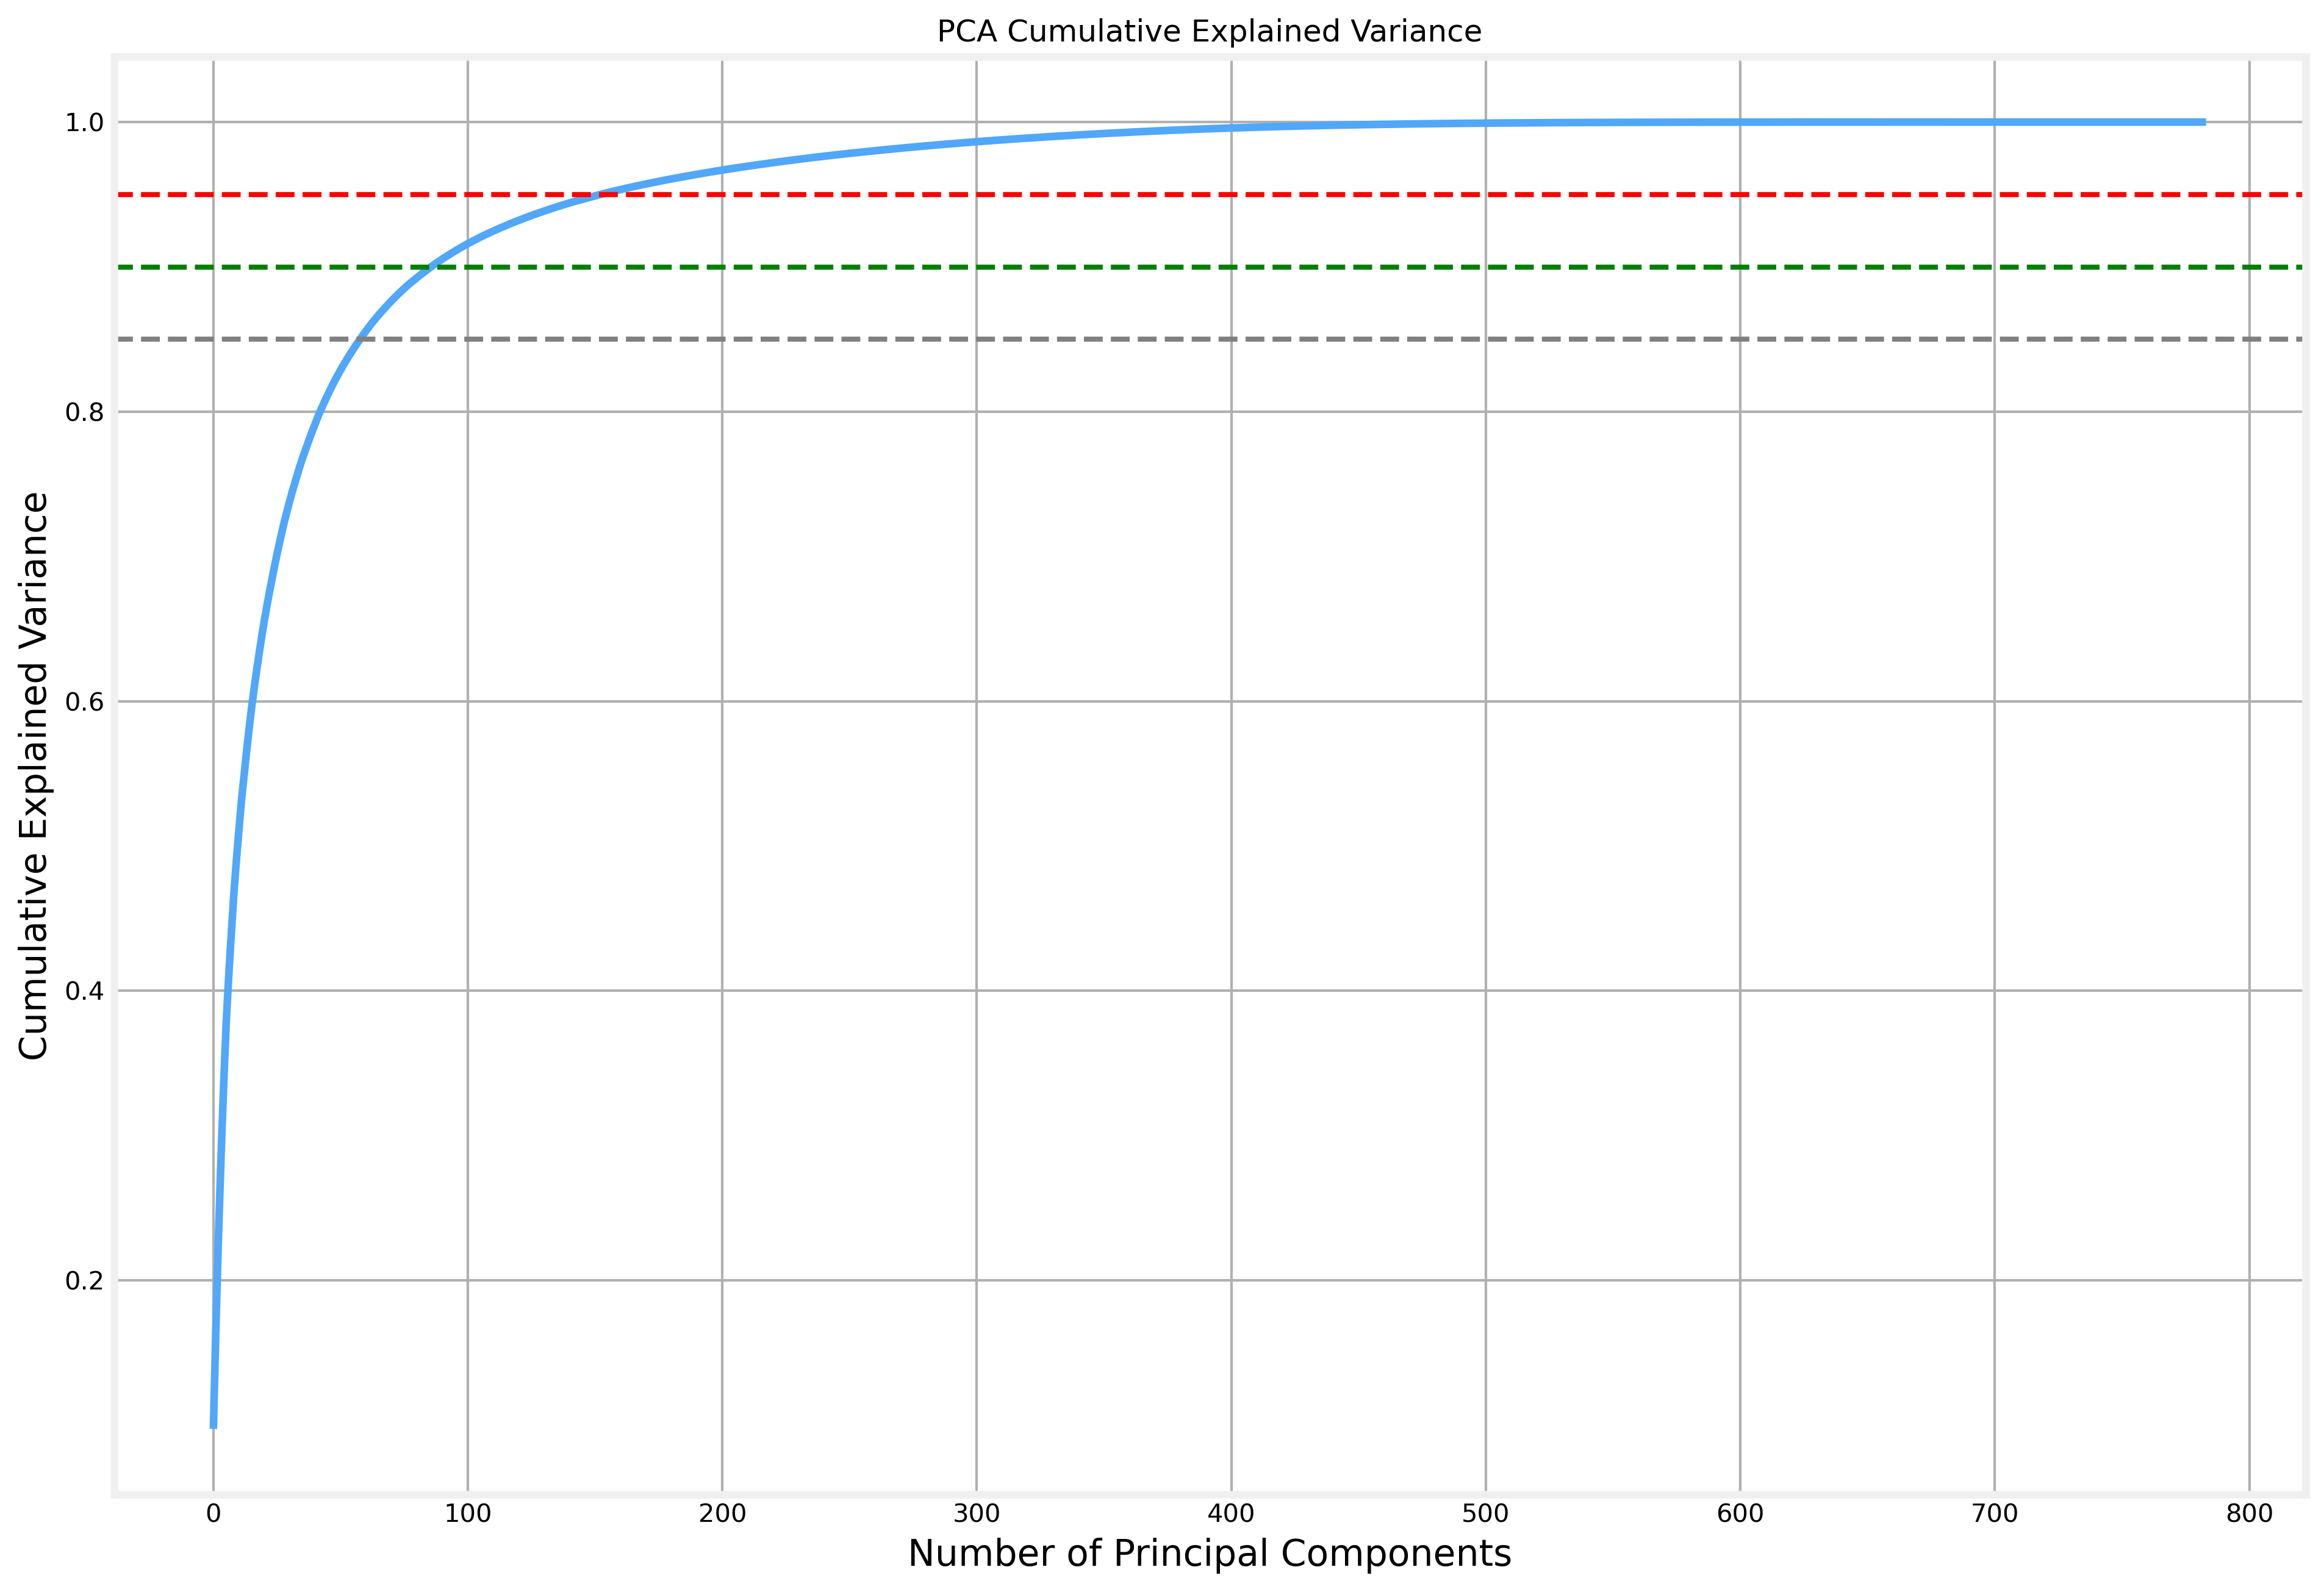

In [16]:
ratio = pca.explained_variance_ratio_
variance_explained_plot(ratio)

In [17]:
def variance_explained(percent, images): 
    # percent needs to be a float from 0 to 1 
    pca = PCA(percent)
    pca.fit(images)
    components = pca.transform(images)
    approx = pca.inverse_transform(components)
    return approx

In [18]:
plt.rcParams['axes.grid'] = False # don't use grid for image plots

##  Plotting PCA transform data

Use the `variance_explained` function, which is provided for you above to plot the first digit of the MNIST training dataset and the different thresholds:
- Orignal image (784 components)
- 95% of explained variance
- 90% of explained variance
- 85% of explained variance

You can use the `show_images` function from milestone 2, which can be found here: `customlib/plotting.py` as an example how to plot images.

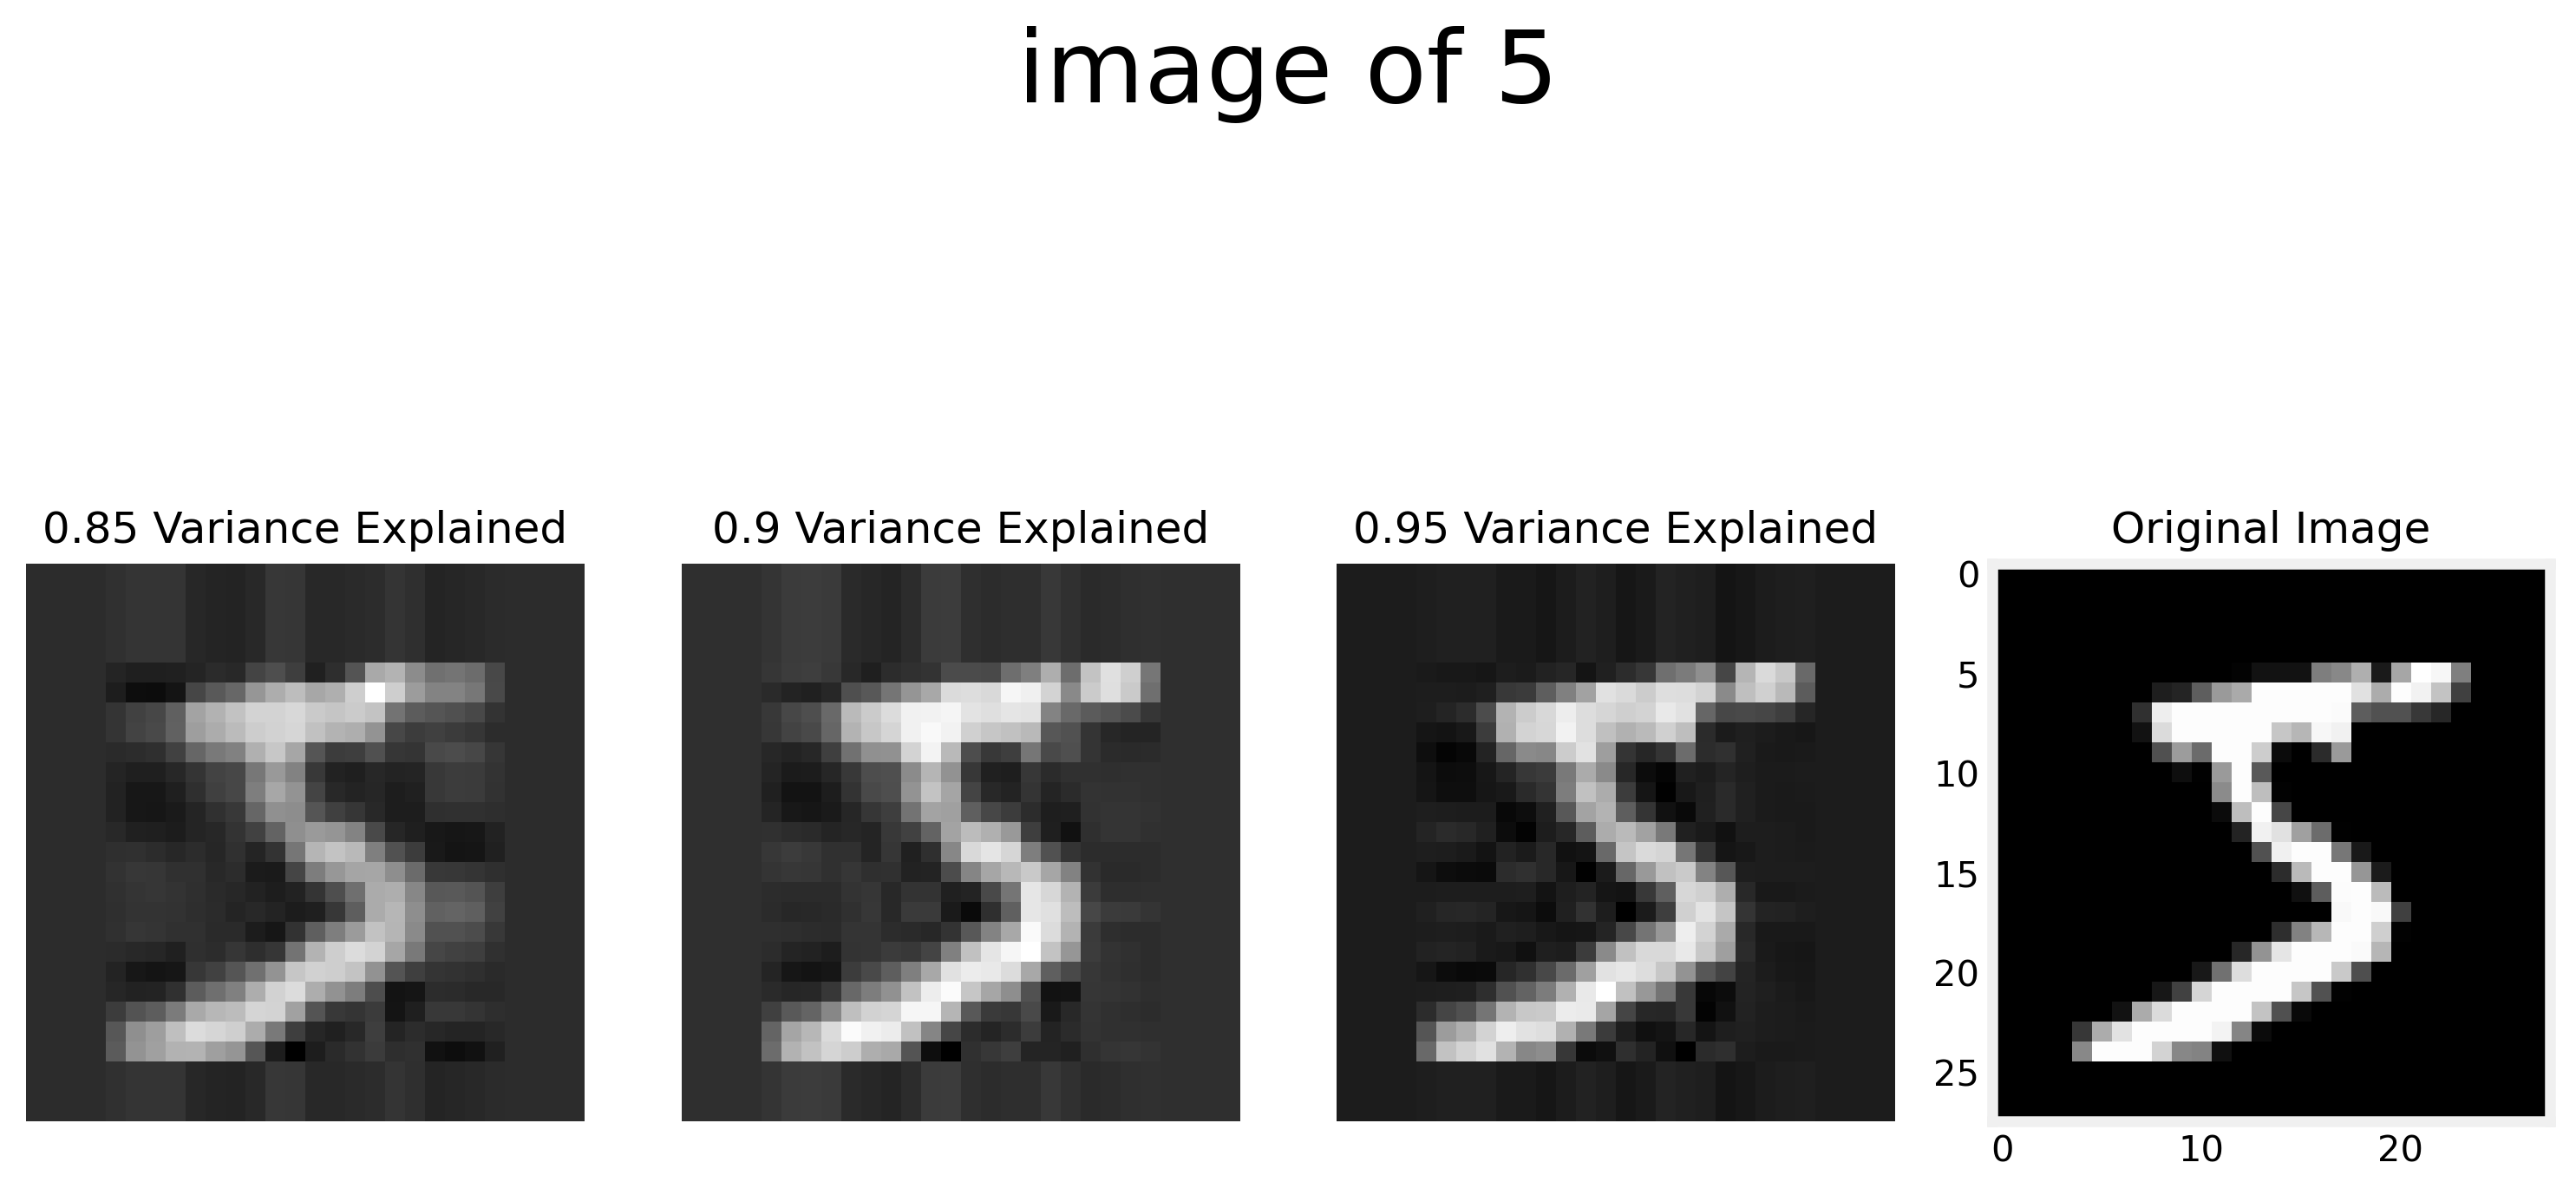

In [19]:
# reshape images into 2D 
images = mnist.data.reshape(-1, 28, 28)
# get the ith approximate image and plot
i  = 0
percent_approx = [0.85, 0.9, 0.95]
plt.figure(figsize=(10,6))

for  idx, p in enumerate(percent_approx):
    approx_image = variance_explained(p, images[i])
    plt.subplot(1, len(percent_approx) + 1, idx + len(percent_approx) -  1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Original Image")
    plt.subplot(1, len(percent_approx) + 1, idx + 1)
    plt.imshow(approx_image, cmap='gray')
    plt.title(f"{p} Variance Explained")
    plt.axis('off')

plt.suptitle(f"image of {mnist.target[i]}",  fontsize=28)   
plt.show()

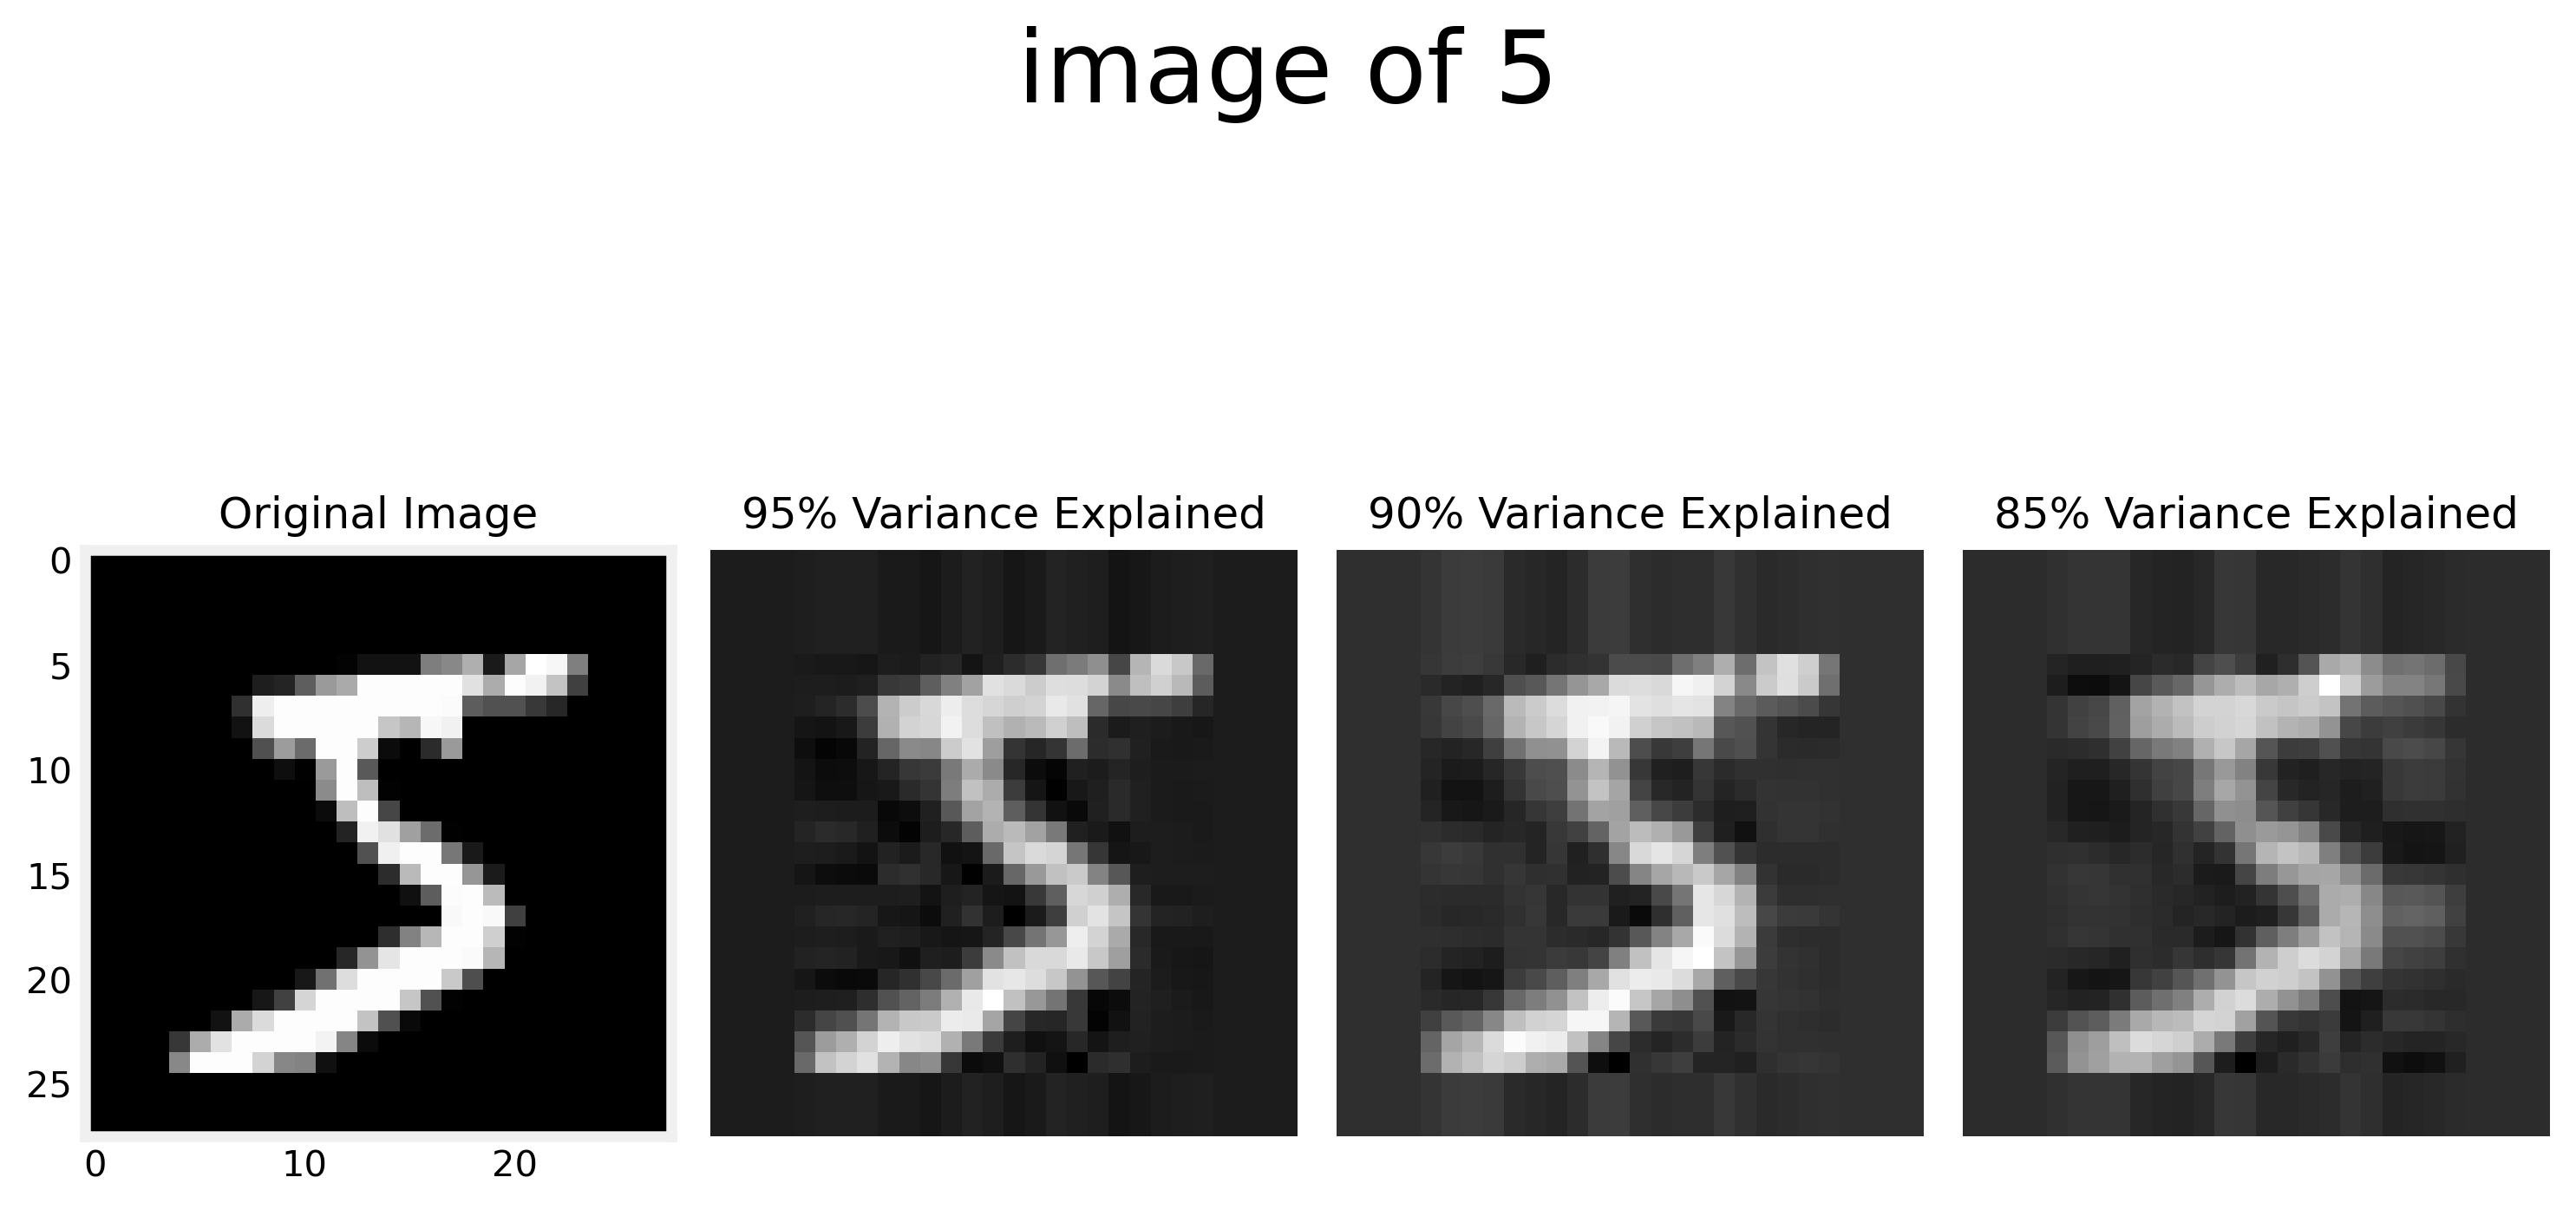

In [22]:
def explained_variance_plot(x_train):
    # get the ith approximate image and plot
    i  = 0
    percent_approx = [0.95, 0.9, 0.85]
    plt.figure(figsize=(10,6))

    for  idx, p in enumerate(percent_approx):
        
        approx_image = variance_explained(p, images[i])
        plt.subplot(1, len(percent_approx) + 1, 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Original Image")
        plt.subplot(1, len(percent_approx) + 1, idx + 2)
        plt.imshow(approx_image, cmap='gray')
        plt.title(f"{round(p*100)}% Variance Explained")
        plt.axis('off')

    plt.suptitle(f"image of {mnist.target[i]}",  fontsize=28)   
    plt.show()
    
explained_variance_plot(x_train)

Compare the running time of the logistic regression without having reduced the dimensionality beforehand and after reducing the number of components to 87 components. Plot the amount of time taken for both models (with and without PCA) as a bar chart [link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html). You can meassure the time as follows: 
- `start = time()`
- `end = time()`
- `time_taken = end-start`

<b>Hint:</b> Don't forget that you first have to use the `PCA` to transform the training and testing data! If you unsure how to 
init the PCA like this: `log_pca = LogisticRegression(solver='lbfgs').fit(x_train_pca, y_train)`

## Logistic  Regression on PCA transform training data

In [32]:
# PCA transformation of the training data before fitting the logistic regression model
# initialize the pca object
pca = PCA(n_components=90) 
# fit (calculate pcs of the data) PCA on the training data and transform 
x_train_pca = pca.fit_transform(x_train)
# transform the test data usinf the same PCA object
x_test_pca = pca.transform(x_test)

start = time()

# train a logistic regression model on the pca transformed data 
log_pca = LogisticRegression(solver='lbfgs').fit(x_train_pca, y_train)
end = time()

pca_time_log_normal = end-start
print(f"Time to fit logistic regression model with pca dim reduced data {pca_time_log_normal}")

Time to fit logistic regression model with pca dim reduced data 1.8867530822753906


In [36]:
# compare with time of fitting the logistic regression model on the original data
print(f"Time to fit logistic regression: {time_log_normal}")

Time to fit logistic regression: 7.638384819030762


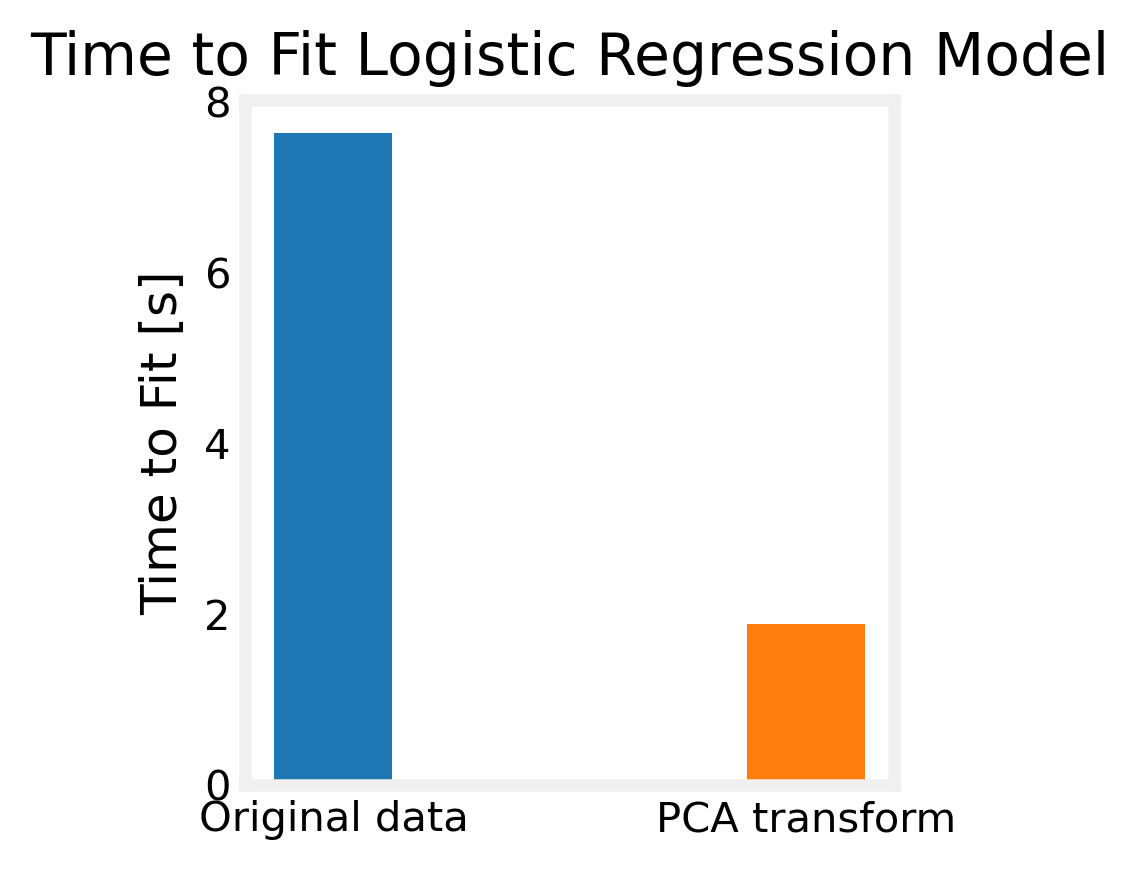

In [37]:
# bar chart of the time to fit the logistic regression model on the original and pca transformed data
fig, ax = plt.subplots(figsize=(3,3))

bar_colors = ['tab:blue', 'tab:orange']
ax.bar(['Original data', 'PCA transform'], 
       [time_log_normal, pca_time_log_normal], 
        color=bar_colors,
        width=0.25)
ax.set_ylabel('Time to Fit [s]',  fontsize=12)
ax.set_title('Time to Fit Logistic Regression Model',  fontsize=14)

plt.show()

##  Accuracy between the prediction with and without PCA

In [38]:
# compare the accuracy of the logistic regression model on the original and pca transformed data
y_preds_train_pca = log_pca.predict(x_train_pca)
y_preds_train     = log_normal.predict(x_train)
y_preds_test_pca  = log_pca.predict(x_test_pca)
y_preds_test      = log_normal.predict(x_test)

model_score_train_pca = accuracy_score(y_train, y_preds_train_pca)
model_score_train     = accuracy_score(y_train, y_preds_train)
model_score_test_pca  = accuracy_score(y_test, y_preds_test_pca)
model_score_test      = accuracy_score(y_test, y_preds_test)

In [39]:
print(f"PCA transform training Set Score: {model_score_train_pca}")
print(f"Original data training Set Score: {model_score_train}")
print(f"PCA transform test Set Score: {model_score_test_pca}")
print(f"Original data test Set Score: {model_score_test}")

PCA transform training Set Score: 0.9163392857142857
Original data training Set Score: 0.9358214285714286
PCA transform test Set Score: 0.9067857142857143
Original data test Set Score: 0.9172142857142858
